# Deploy: Comparison detection Yolov8 vs Yolov10

## Get converted onnx model using Ultraltyics

In [118]:
%%capture
# Install ultralytcs library
!pip install ultralytics

In [2]:
%%capture
!pip install onnxruntime-gpu==1.18.0   # cuda 11.8 --> onnxruntime 1.16.0

In [116]:
%%capture
!pip install git+https://github.com/THU-MIG/yolov10.git

In [4]:
%%capture
!wget https://ultralytics.com/images/bus.jpg

In [127]:
from ultralytics import YOLO, YOLOv10
# Convert model
# you can visualize the model using netron https://netron.app/
def convert_model_yolov8(model_path):
    # Export model
    m = YOLO(model_path)
    m.export( format="onnx", opset=15,  dynamic=True) #, simplify=True) imgsz=640

def convert_model_yolov10(model_path):
    # Export model
    m = YOLO(model_path)
    m.export( format="onnx", opset=15,  dynamic=True) #, simplify=True) imgsz=640


In [ ]:
# Convert yolov8n.py
yolov8_model_path = "yolov8n.pt"
convert_model_yolov8(yolov8_model_path)

In [125]:
%%capture
#!wget https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10{n/s/m/b/l/x}.pt
!wget https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt

In [128]:
# Convert yolov10n.pt
yolov10_model_path = "yolov10.pt"
convert_model_yolov10(yolov10_model_path)

FileNotFoundError: [Errno 2] No such file or directory: 'yolov10.pt'

 ## Load Libraries

In [57]:
import onnxruntime as rt
import numpy as np
import cv2
import os
from PIL import Image
import time

## Ultralytics infere Yolov10

In [58]:
# https://onnxruntime.ai/docs/api/python/api_summary.html

class Yolov10Inference:
    def __init__(self, model_path,classes):
        providers = ["CUDAExecutionProvider","CPUExecutionProvider"]
        self.inf = rt.InferenceSession(model_path,  providers=providers)
        self.model_width = 640
        self.model_height = 640
        self.score_threshold = 0.5
        self.classes = classes

        # Get input name
        self.input_names = []
        for i in range(0, len(self.inf.get_inputs())):
            input_name = self.inf.get_inputs()[i].name
            self.input_names.append(input_name)
            print(f"input_{i}: {input_name}")

        self.output_names = []
        for i in range(0, len(self.inf.get_outputs())):
            output_name = self.inf.get_outputs()[i].name
            self.output_names.append(output_name)
            print(f"output_{i}: {output_name}")

    def preprocess(self, im):
        # image is rgb
        self.height = im.shape[0]
        self.width = im.shape[1]
        self.scale_y = self.height/self.model_height
        self.scale_x = self.width/self.model_width
        self.im = im.copy()
        x = cv2.resize(im, (self.model_width,self.model_height), interpolation=cv2.INTER_AREA)
        x = x.astype(np.float32) / 255.0
        x = np.transpose(x, (2,0,1))
        x = x[np.newaxis,:,:,:]
        return x

    def postprocess_yolov8(self):
        # yolov8n: 1-84-8400
        pass

    def postprocess(self,output0):
        # output0.shape = yolov10: 1-300-6
        im_draw = self.im.copy()
        n_achor = output0.shape[1]
        for i in range(0, n_achor):
            box = output0[0,i,0:4]
            x1 = int(box[0]*self.scale_x) # center box x already wrt 640
            y1 = int(box[1]*self.scale_y) # benter box y already wrt 640
            x2 = int(box[2]*self.scale_x) # width
            y2 = int(box[3]*self.scale_y) # height
            # 4-84
            score =  output0[0,i,4]
            if score > 0.5:
                cv2.rectangle(im_draw, (x1, y1), (x2, y2), (255, 0, 0), 1)
        return im_draw

    def run(self,im):
        x = self.preprocess(im)
        outputs = self.inf.run(None, {"images": x})
        output0 = outputs[0]
        im_draw = self.postprocess(output0)
        return im_draw


input_0: images
output_0: output0


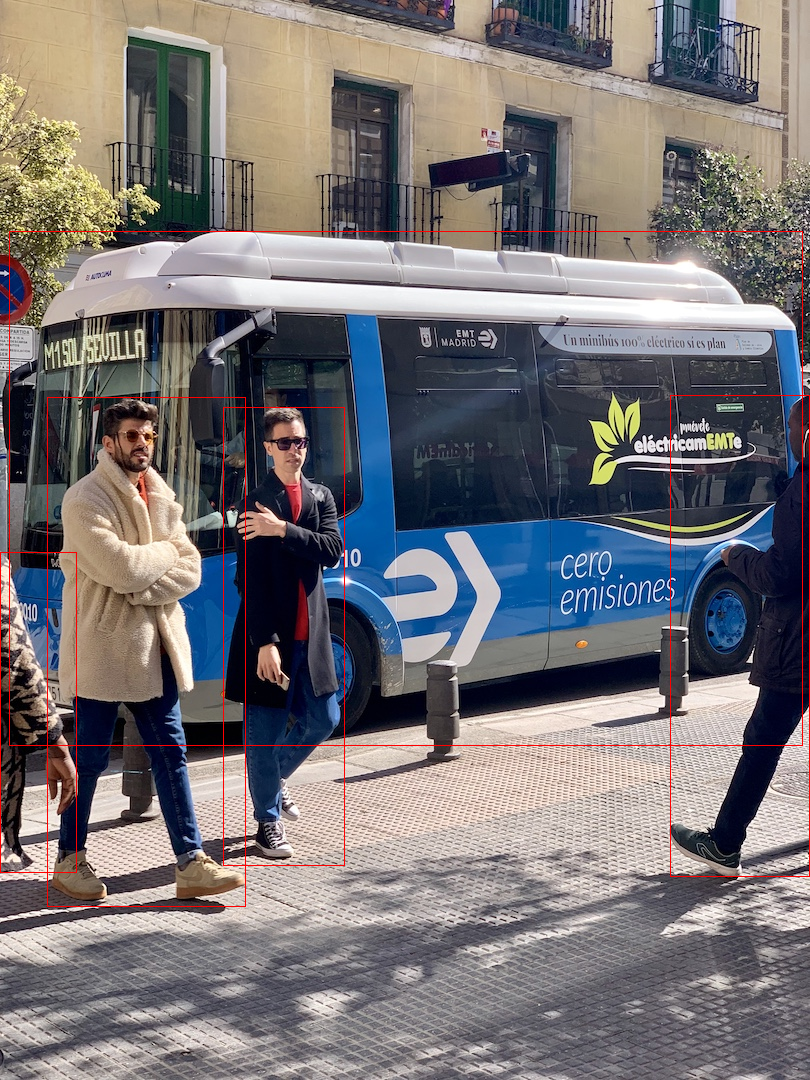

In [73]:
# coco classes
classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush']

model_path_v10 = "yolov10n.onnx"
image_path = "bus.jpg"

# Lettura immagine
im_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)

inf_yolov10 = Yolov10Inference(model_path_v10, classes)
im_draw = inf_yolov10.run(im_rgb)
display(Image.fromarray(im_draw))

## YOLOV8 ONNRUNTIME

In [111]:
class Yolov8Inference:
    def __init__(self, model_path, classes):
        providers = ["CUDAExecutionProvider","CPUExecutionProvider"]
        self.inf = rt.InferenceSession(model_path,  providers=providers)
        self.model_width = 640
        self.model_height = 640
        self.score_threshold = 0.5
        self.iou_threshold = 0.5
        self.classes = classes

        # Get input name
        self.input_names = []
        for i in range(0, len(self.inf.get_inputs())):
            input_name = self.inf.get_inputs()[i].name
            self.input_names.append(input_name)
            print(f"input_{i}: {input_name}")

        self.output_names = []
        for i in range(0, len(self.inf.get_outputs())):
            output_name = self.inf.get_outputs()[i].name
            self.output_names.append(output_name)
            print(f"output_{i}: {output_name}")

    def preprocess(self, im):
        # image is rgb
        self.height = im.shape[0]
        self.width = im.shape[1]
        self.scale_y = self.height/self.model_height
        self.scale_x = self.width/self.model_width
        self.im = im.copy()
        x = cv2.resize(im, (self.model_width,self.model_height), interpolation=cv2.INTER_AREA)
        x = x.astype(np.float32) / 255.0
        x = np.transpose(x, (2,0,1))
        x = x[np.newaxis,:,:,:]
        return x

    def postprocess(self,output0):
        # output0.shape = yolov8: 1-84-8400
        num_classes = len(self.classes) #80
        n_anchor = output0.shape[2] # 8400
        im_draw = self.im.copy()
        boxes_list = []
        scores_list = []
        for i in range(0, n_anchor):
            box = output0[0,0:4,i]
            x1 = int( box[0]*self.scale_x ) # center box x already wrt 640
            y1 = int( box[1]*self.scale_y ) # benter box y already wrt 640
            x2 = int( box[2]*self.scale_x ) # width
            y2 = int( box[3]*self.scale_y ) # height

            # 4-84
            scores =  output0[0,4:(num_classes+4),i]
            idx = np.argmax( scores)
            score = scores[idx]
            if score > self.score_threshold:
                boxes_list.append([x1,y1,x2,y2])
                scores_list.append(score)

        indices = cv2.dnn.NMSBoxes(boxes_list, scores_list, self.score_threshold, self.iou_threshold)
        for index in indices:
            box = boxes_list[index]
            x1, y1, x2, y2 = np.array(box).astype(int)
            score = scores_list[index]
            cv2.rectangle(im_draw, (x1, y1), (x2, y2), (0, 255, 0), 1)

        return im_draw

    def run(self,im):
        x = self.preprocess(im)
        outputs = self.inf.run(None, {"images": x})
        output0 = outputs[0]
        im_draw = self.postprocess(output0)
        return im_draw


input_0: images
output_0: output0
(1, 3, 640, 640)


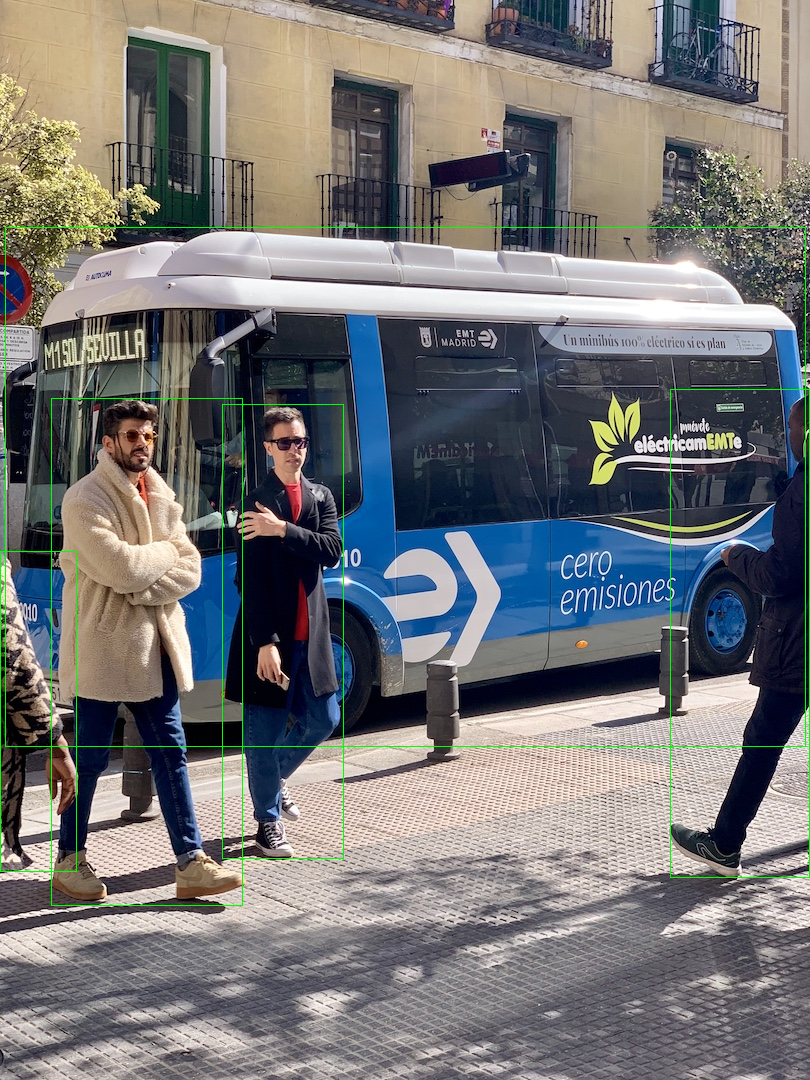

In [112]:
# coco classes
classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush']

model_path_v8 = "yolov8n.onnx"
image_path = "bus.jpg"

# Lettura immagine
im_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)

inf_yolov8 = Yolov8Inference(model_path_v8, classes)
im_draw = inf_yolov8.run(im_rgb)
display(Image.fromarray(im_draw))